In [ ]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
from tabpfn import TabPFNRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap

rcParams['axes.titlepad'] = 12
rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [7.8, 5.8]
rcParams['figure.titlesize'] = 25
rcParams['font.size'] = 25.0
rcParams['legend.fontsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['ytick.labelsize'] = 25

In [ ]:
def generate_var(rho, d):
    idx = np.arange(1, d + 1)
    return np.power(rho, abs(np.subtract.outer(idx, idx)))


def create_sparse_vector(p, s):
    # Create array of zeros
    vec = np.zeros(p)

    # Calculate indices for 1s
    indices = np.linspace(0, p - 1, s, dtype=int)

    # Set those indices to 1
    vec[indices] = 1

    return vec


def data_gen(n, d, s, rho, nu=0.1, beta_type=1, X_var="identity", seed=0):
    np.random.seed(seed)
    if X_var == "identity":
        X = np.random.randn(n, d)
        beta = np.concatenate([np.ones(s), np.zeros(d - s)])
        error_var = np.sum(beta**2) / nu

    elif X_var == "band":
        var = generate_var(rho, d)
        mean = np.zeros(d)
        X = np.random.multivariate_normal(mean, var, n)
        if beta_type == 1:
            beta = np.concatenate([np.ones(s), np.zeros(d - s)])
        elif beta_type == 2:
            beta = create_sparse_vector(d, s)
        error_var = np.sum(var.dot(beta) * beta) / nu
    y = X.dot(beta) + np.sqrt(error_var) * np.random.randn(n)

    return X, y


def quantile_ied(x_vec, q):
    """
    Inverse of empirical distribution function (quantile R type 1).

    More details in
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html
    https://stat.ethz.ch/R-manual/R-devel/library/stats/html/quantile.html
    https://en.wikipedia.org/wiki/Quantile

    Arguments:
    x_vec -- A pandas series containing the values to compute the quantile for
    q -- An array of probabilities (values between 0 and 1)
    """
    x_vec = x_vec.sort_values()
    n = len(x_vec) - 1
    m = 0
    j = (n * q + m).astype(int)  # location of the value
    g = n * q + m - j

    gamma = (g != 0).astype(int)
    quant_res = (1 - gamma) * x_vec.shift(1, fill_value=0).iloc[j] + gamma * x_vec.iloc[
        j
    ]
    quant_res.index = q
    # add min at quantile zero and max at quantile one (if needed)
    if 0 in q:
        quant_res.loc[0] = x_vec.min()
    if 1 in q:
        quant_res.loc[1] = x_vec.max()
    return quant_res


def aleplot_1D_continuous(X, model, feature, grid_size=20, include_CI=True, C=0.95):
    """Compute the accumulated local effect of a numeric continuous feature.

    This function divides the feature in question into grid_size intervals (bins)
    and computes the difference in prediction between the first and last value
    of each interval and then centers the results.

    Arguments:
    X -- A pandas DataFrame to pass to the model for prediction.
    model -- Any python model with a predict method that accepts X as input.
    feature -- String, the name of the column holding the feature being studied.
    grid_size -- An integer indicating the number of intervals into which the
    feature range is divided.
    include_CI -- A boolean, if True the confidence interval
    of the effect is returned with the results.
    C -- A float the confidence level for which to compute the confidence interval

    Return: A pandas DataFrame containing for each bin: the size of the sample in it
    and the accumulated centered effect of this bin.
    """

    quantiles = np.linspace(0, 1, grid_size + 1, endpoint=True)
    # use customized quantile function to get the same result as
    # type 1 R quantile (Inverse of empirical distribution function)
    # print("test", X[feature].sort_values())
    bins = [X[feature].min()] + quantile_ied(X[feature], quantiles).to_list()
    bins = np.unique(bins)
    feat_cut = pd.cut(X[feature], bins, include_lowest=True)

    bin_codes = feat_cut.cat.codes

    X1 = X.copy()
    X2 = X.copy()
    X1[feature] = [bins[i] for i in bin_codes]
    X2[feature] = [bins[i + 1] for i in bin_codes]
    try:
        y_1 = model.predict(X1).ravel()
        y_2 = model.predict(X2).ravel()
    except Exception as ex:
        raise Exception(
            "Please check that your model is fitted, and accepts X as input."
        )

    delta_df = pd.DataFrame({feature: bins[bin_codes + 1], "Delta": y_2 - y_1})
    res_df = delta_df.groupby([feature], observed=False).Delta.agg(
        [("eff", "mean"), "size"]
    )
    res_df["eff"] = res_df["eff"].cumsum()
    res_df.loc[min(bins), :] = 0
    # subtract the total average of a moving average of size 2
    mean_mv_avg = (
        (res_df["eff"] + res_df["eff"].shift(1, fill_value=0)) / 2 * res_df["size"]
    ).sum() / res_df["size"].sum()
    res_df = res_df.sort_index().assign(eff=res_df["eff"] - mean_mv_avg)
    if include_CI:
        ci_est = delta_df.groupby(feature, observed=False).Delta.agg(
            [("CI_estimate", lambda x: CI_estimate(x, C=C))]
        )
        ci_est = ci_est.sort_index()
        lowerCI_name = "lowerCI_" + str(int(C * 100)) + "%"
        upperCI_name = "upperCI_" + str(int(C * 100)) + "%"
        res_df[lowerCI_name] = res_df[["eff"]].subtract(ci_est["CI_estimate"], axis=0)
        res_df[upperCI_name] = upperCI = res_df[["eff"]].add(
            ci_est["CI_estimate"], axis=0
        )
    return res_df

In [10]:
seed = 1
n = 1000
X, y = data_gen(n + 10000,
            50,
            3,
            0.35,
                nu=0.05,
                beta_type=1,
                X_var="identity",
                seed=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=seed)

/tmp/ipykernel_106973/1936015763.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap('viridis')


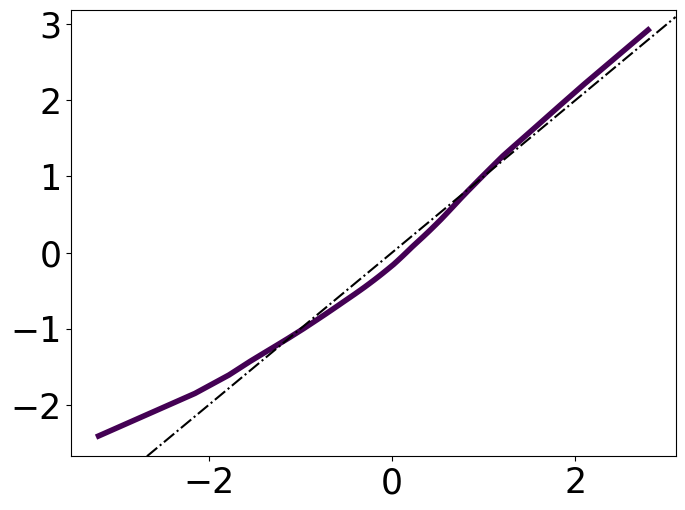

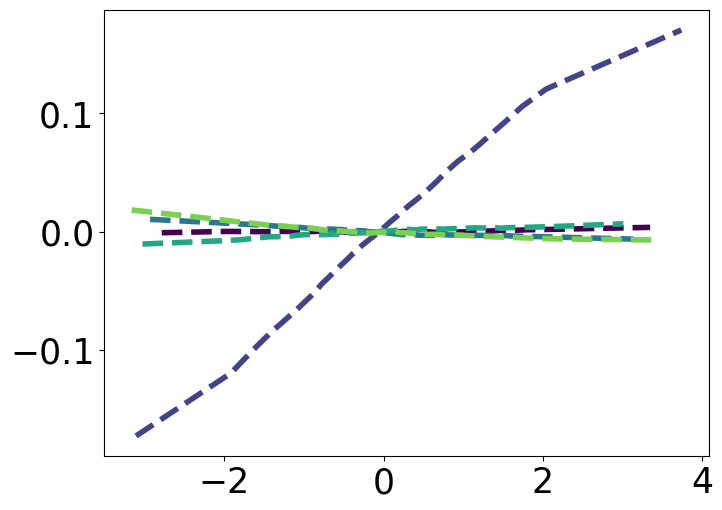

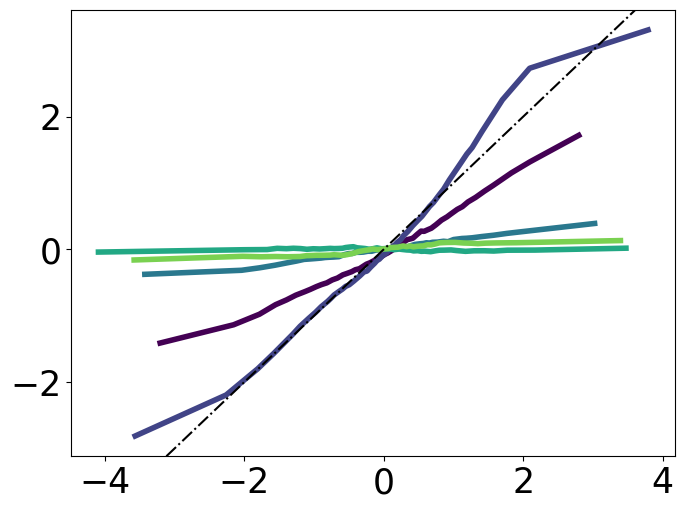

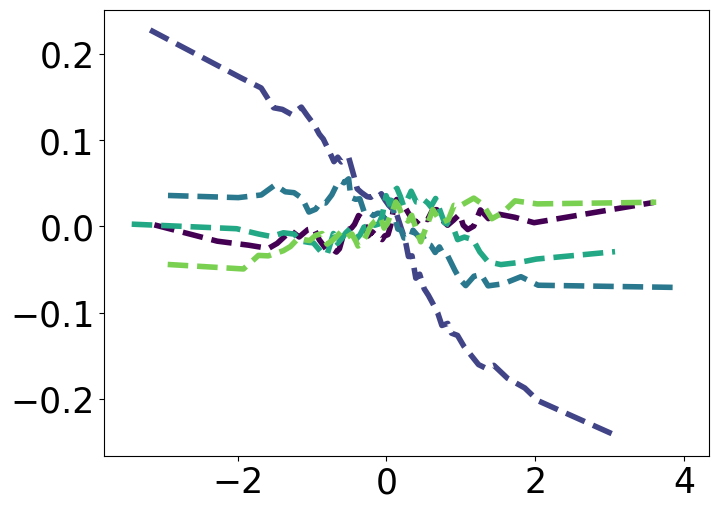

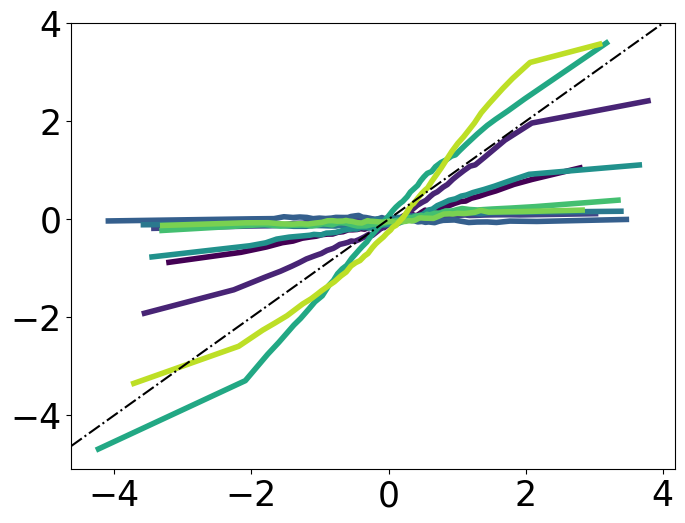

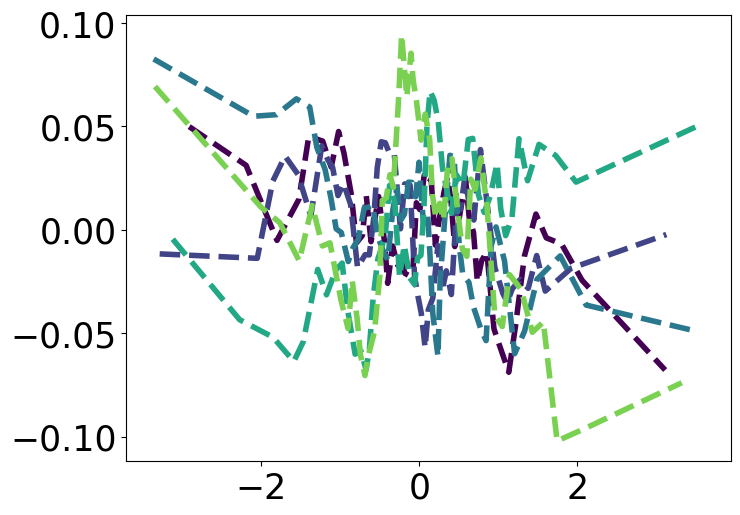

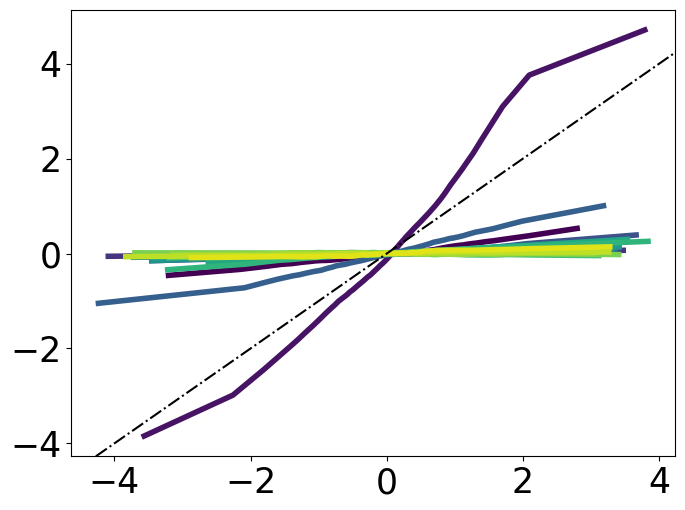

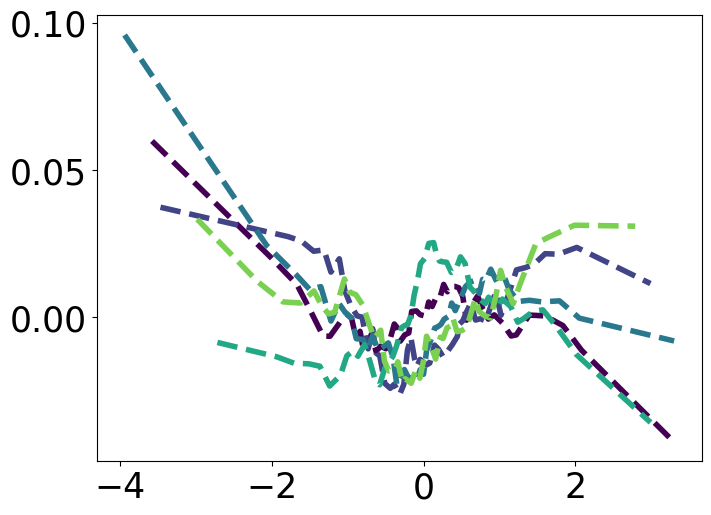

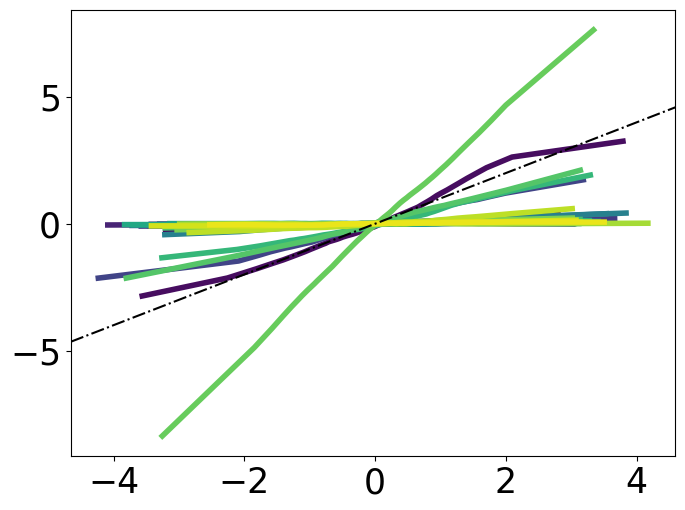

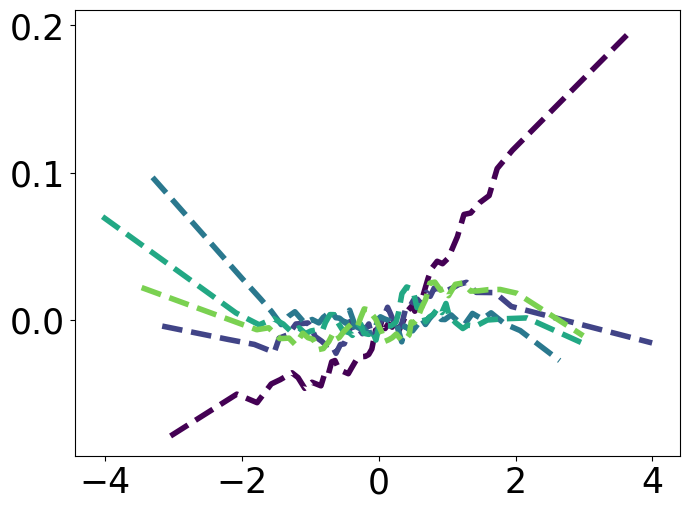

In [3]:
n = 50
d = 100
beta_type = 1
X_var = "identity"
seed = 1
rho = 0.35
nu = 1.22
viridis = get_cmap('viridis')


# for s in [10]:    
for s in [1, 5, 10, 20, 30]:    
    X, y = data_gen(n + 1000,
                    d,
                    s,
                    rho,
                    nu=nu,
                    beta_type=beta_type,
                    X_var=X_var,
                    seed=seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=seed)
    regressor = TabPFNRegressor(
            model_path="/root/autodl-tmp/pfn/tabpfn-v2-regressor.ckpt")
    regressor.fit(X_train, y_train)
    X = pd.DataFrame(X)
       
    fig, ax = plt.subplots()
    for i in range(s):
        color = viridis(i/s)
        res_df = aleplot_1D_continuous(X, model=regressor, feature=i, grid_size=50, include_CI=False)
        plt.plot(res_df[["eff"]], linewidth=4, color=color, label="var. " + str(i))
    ax.axline((0, 0), slope=1, color='black', linestyle='-.')

    plt.savefig("ale_plot/ale_relevant_feature_n50_d100_snr122_s_" + str(s) + ".png", orientation="landscape", dpi=300, bbox_inches="tight")
    
    fig, ax = plt.subplots()
    indices = np.random.choice(np.arange(s,d),5)
    for i, idx in enumerate(indices):
        color = viridis(i/5)
        res_df = aleplot_1D_continuous(X, model=regressor, feature=idx, grid_size=50, include_CI=False)
        plt.plot(res_df[["eff"]], color=color, linestyle='dashed', linewidth=4)
    plt.savefig("ale_plot/ale_irrelevant_feature_n50_d100_snr122_s_" + str(s) + ".png", orientation="landscape", dpi=300, bbox_inches="tight")

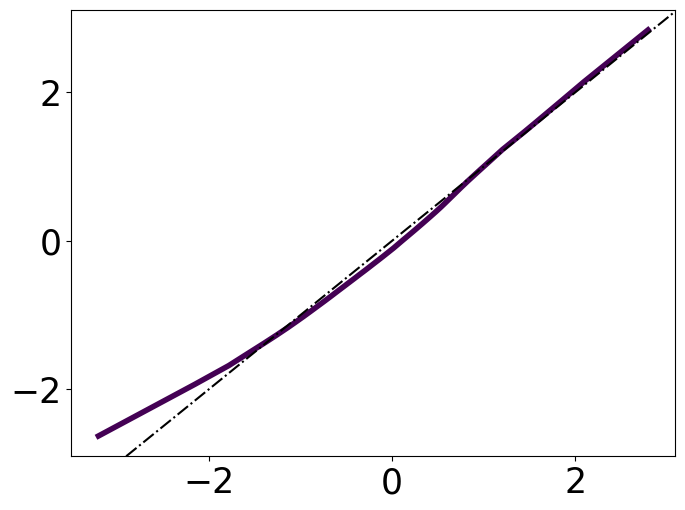

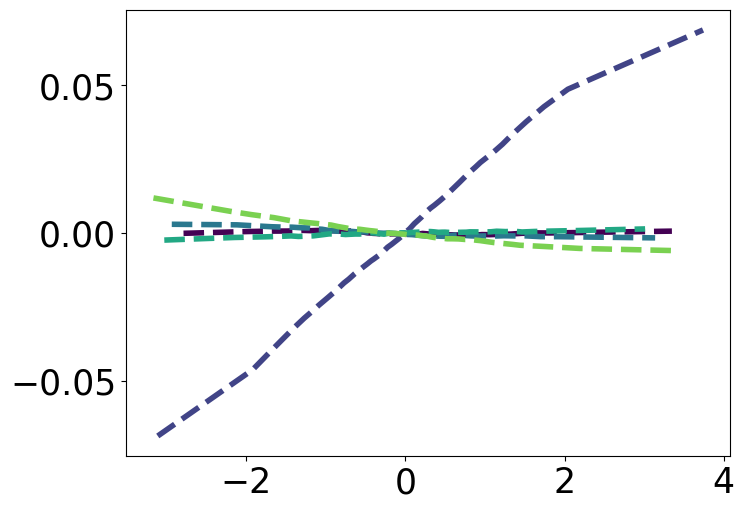

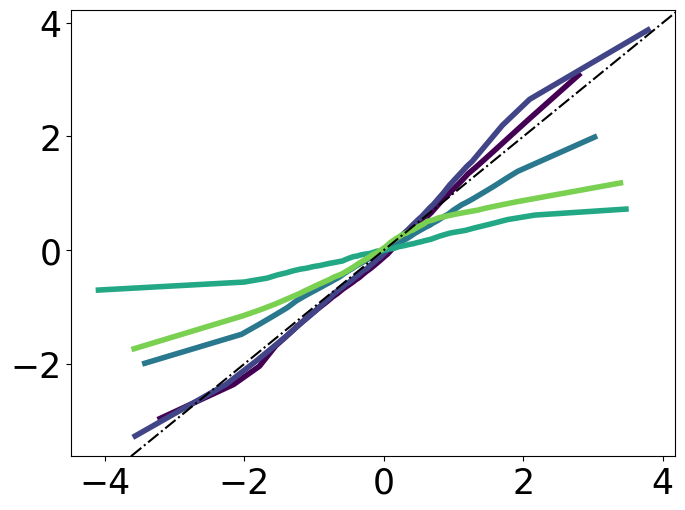

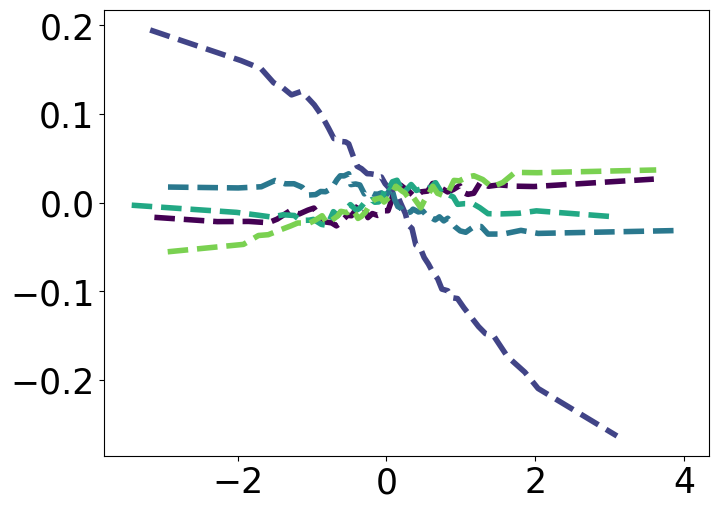

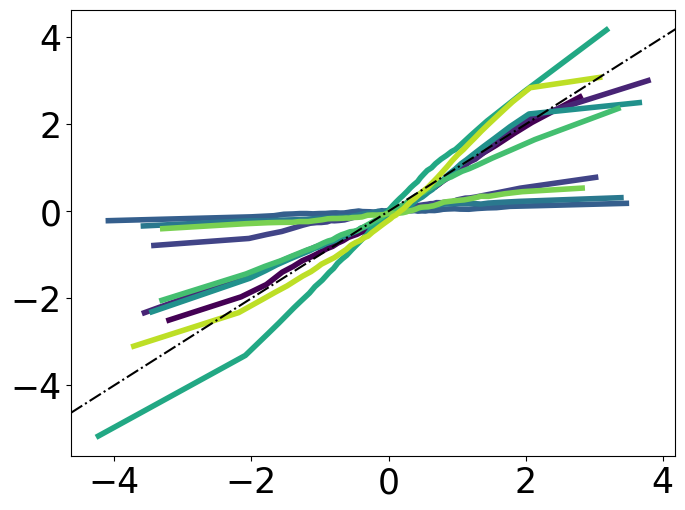

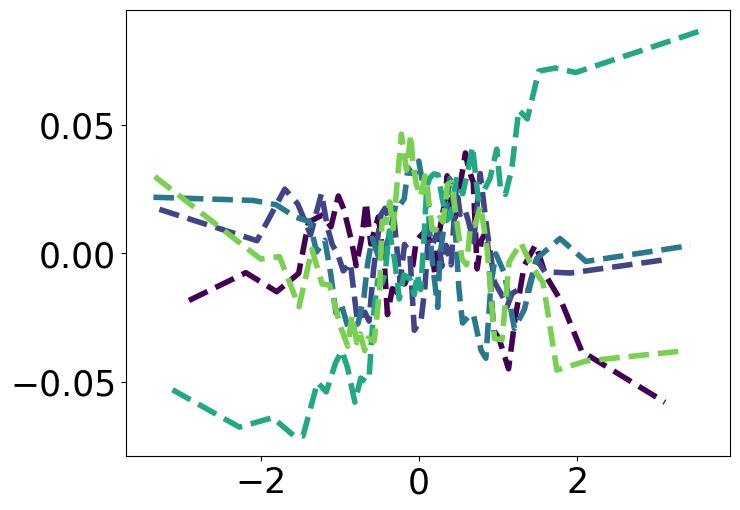

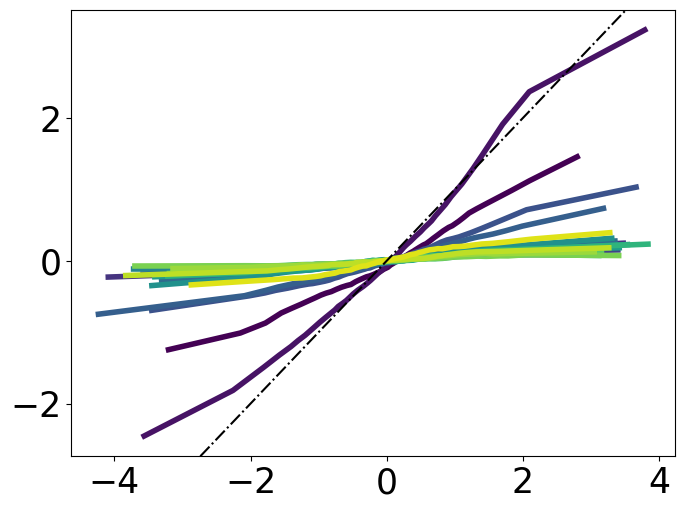

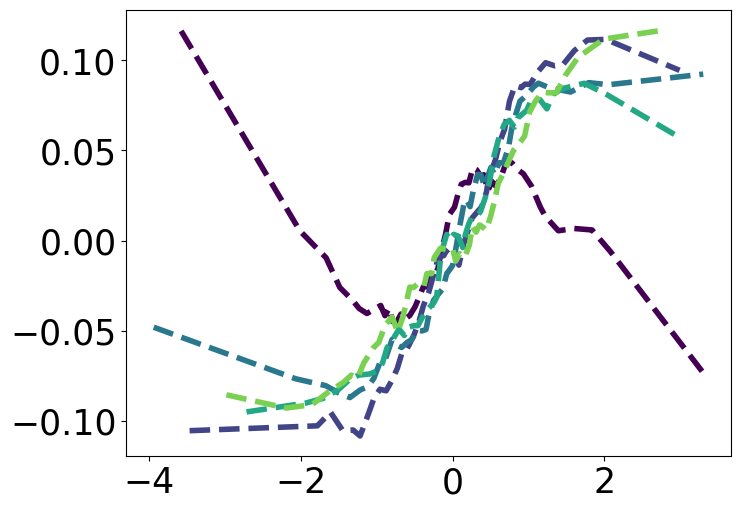

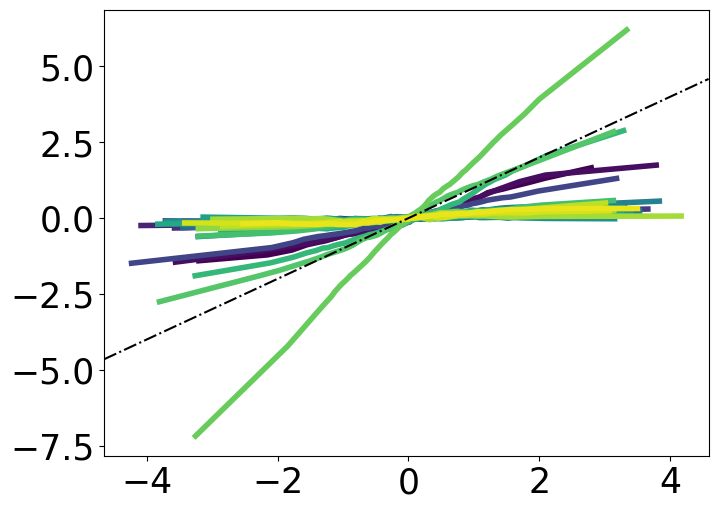

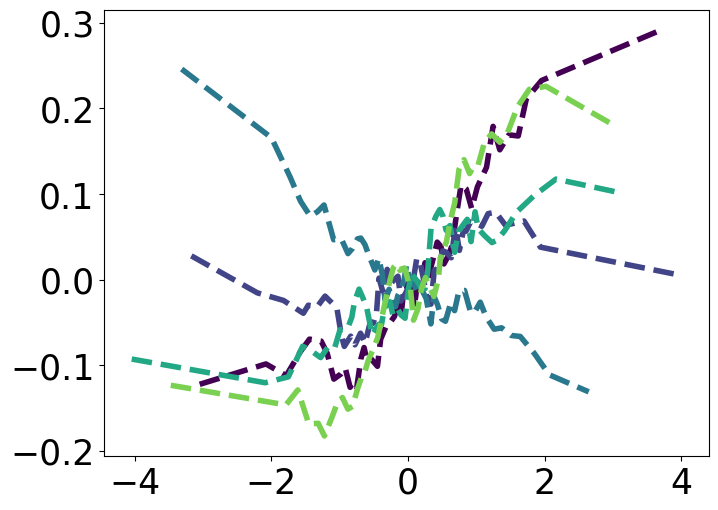

In [5]:
n = 50
d = 100
beta_type = 1
X_var = "identity"
seed = 1
rho = 0.35
nu = 6


for s in [1, 5, 10, 20, 30]:    
    X, y = data_gen(n + 1000,
                    d,
                    s,
                    rho,
                    nu=nu,
                    beta_type=beta_type,
                    X_var=X_var,
                    seed=seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=seed)
    regressor = TabPFNRegressor(
            model_path="/root/autodl-tmp/pfn/tabpfn-v2-regressor.ckpt")
    regressor.fit(X_train, y_train)
    X = pd.DataFrame(X)
       
    fig, ax = plt.subplots()
    for i in range(s):
        color = viridis(i/s)
        res_df = aleplot_1D_continuous(X, model=regressor, feature=i, grid_size=50, include_CI=False)
        plt.plot(res_df[["eff"]], linewidth=4, color=color, label="var. " + str(i))
    ax.axline((0, 0), slope=1, color='black', linestyle='-.')
    plt.savefig("ale_plot/ale_relevant_feature_n50_d100_snr6_s_" + str(s) + ".png", orientation="landscape", dpi=300, bbox_inches="tight")
    
    fig, ax = plt.subplots()
    indices = np.random.choice(np.arange(s,d),5)
    for i, idx in enumerate(indices):
        color = viridis(i/5)
        res_df = aleplot_1D_continuous(X, model=regressor, feature=idx, grid_size=50, include_CI=False)
        plt.plot(res_df[["eff"]], color=color, linestyle='dashed', linewidth=4)
    plt.savefig("ale_plot/ale_irrelevant_feature_n50_d100_snr6_s_" + str(s) + ".png", orientation="landscape", dpi=300, bbox_inches="tight")